In [42]:
import pandas as pd
import geopandas as gpd
import ee
from utils import *
from config import *

#### Section 1 - Loading the Per-County WNV Human, Mosquito, Animal, Mammal Case CSV files.

In [43]:
df_IL = gpd.read_file(r".\shapefiles\IL County SHP\IL County SHP\IL_County.shp")
wnv_human = pd.read_csv(r".\wnv_case_data\WNV_Human_Cases_per_100k.csv")
wnv_hosts = pd.read_csv(r".\wnv_case_data\Updated_WNV_Animal_Health_Data.csv")

<Axes: >

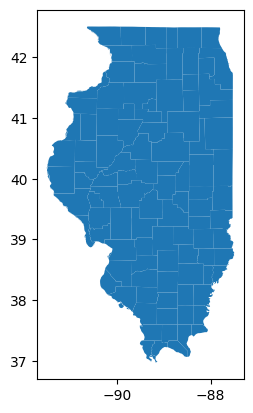

In [44]:
df_IL.plot()

##### Filtering for 2017-2023

In [56]:
wnv_human.columns

Index(['Unnamed: 0', 'FIPS', 'County', 'State', 'Population', 'X', 'Y',
       'HC_2002', 'HC_2003', 'HC_2004', 'HC_2005', 'HC_2006', 'HC_2007',
       'HC_2008', 'HC_2009', 'HC_2010', 'HC_2011', 'HC_2012', 'HC_2013',
       'HC_2014', 'HC_2015', 'HC_2016', 'HC_2017', 'HC_2018', 'HC_2019',
       'HC_2020', 'HC_2021', 'HC_2022', 'HC_2023', 'HC_2024',
       'HC_2002_per_100k', 'HC_2003_per_100k', 'HC_2004_per_100k',
       'HC_2005_per_100k', 'HC_2006_per_100k', 'HC_2007_per_100k',
       'HC_2008_per_100k', 'HC_2009_per_100k', 'HC_2010_per_100k',
       'HC_2011_per_100k', 'HC_2012_per_100k', 'HC_2013_per_100k',
       'HC_2014_per_100k', 'HC_2015_per_100k', 'HC_2016_per_100k',
       'HC_2017_per_100k', 'HC_2018_per_100k', 'HC_2019_per_100k',
       'HC_2020_per_100k', 'HC_2021_per_100k', 'HC_2022_per_100k',
       'HC_2023_per_100k', 'HC_2024_per_100k'],
      dtype='object')

In [57]:
wnv_hosts.columns

Index(['FIPS', 'County', 'State', 'Population', 'X', 'Y', 'Total_Birds_2002',
       'Mosquito_Batch_2002', 'Total_Mammals_2002', 'Total_Birds_2003',
       'Mosquito_Batch_2003', 'Total_Mammals_2003', 'Total_Birds_2004',
       'Mosquito_Batch_2004', 'Total_Mammals_2004', 'Total_Birds_2005',
       'Mosquito_Batch_2005', 'Total_Mammals_2005', 'Total_Birds_2006',
       'Mosquito_Batch_2006', 'Total_Mammals_2006', 'Total_Birds_2007',
       'Mosquito_Batch_2007', 'Total_Mammals_2007', 'Total_Birds_2008',
       'Mosquito_Batch_2008', 'Total_Mammals_2008', 'Total_Birds_2009',
       'Mosquito_Batch_2009', 'Total_Mammals_2009', 'Total_Birds_2010',
       'Mosquito_Batch_2010', 'Total_Mammals_2010', 'Total_Birds_2011',
       'Mosquito_Batch_2011', 'Total_Mammals_2011', 'Total_Birds_2012',
       'Mosquito_Batch_2012', 'Total_Mammals_2012', 'Total_Birds_2013',
       'Mosquito_Batch_2013', 'Total_Mammals_2013', 'Total_Birds_2014',
       'Mosquito_Batch_2014', 'Total_Mammals_2014', 'Total

In [58]:
# df_human and df_host will only include 2017 to 2023 data
str_years = ["2017","2018","2019","2020","2021","2022","2023"]

df_human = wnv_human.copy()
df_hosts = wnv_hosts.copy()

human_matching_columns = [col for col in df_human.columns if any(s in col for s in str_years)]
hosts_matching_columns = [col for col in df_hosts.columns if any(s in col for s in str_years)]

df_human = df_human[human_matching_columns]
df_hosts = df_hosts[hosts_matching_columns]

# need fips for merging with embeddings data in section 3
df_human["county_fips"] = wnv_human['FIPS']
df_hosts["county_fips"] = wnv_hosts['FIPS']


In [59]:
print(list(df_human.head(1).columns))
print(list(df_hosts.head(1).columns))

['HC_2017', 'HC_2018', 'HC_2019', 'HC_2020', 'HC_2021', 'HC_2022', 'HC_2023', 'HC_2017_per_100k', 'HC_2018_per_100k', 'HC_2019_per_100k', 'HC_2020_per_100k', 'HC_2021_per_100k', 'HC_2022_per_100k', 'HC_2023_per_100k', 'county_fips']
['Total_Birds_2017', 'Mosquito_Batch_2017', 'Total_Mammals_2017', 'Total_Birds_2018', 'Mosquito_Batch_2018', 'Total_Mammals_2018', 'Total_Birds_2019', 'Mosquito_Batch_2019', 'Total_Mammals_2019', 'Total_Birds_2020', 'Mosquito_Batch_2020', 'Total_Mammals_2020', 'Total_Birds_2021', 'Mosquito_Batch_2021', 'Total_Mammals_2021', 'Total_Birds_2022', 'Mosquito_Batch_2022', 'Total_Mammals_2022', 'Total_Birds_2023', 'Mosquito_Batch_2023', 'Total_Mammals_2023', 'county_fips']


In [60]:
# need to break these two dataframes into 4 dataframes
# -> df_human, df_mosquito, df_bird, df_mammal

print(df_human.shape)
print(df_hosts.shape)

(102, 15)
(102, 22)


#### Section 2 - Main Script to Pull GEE Embeddings for 2017  

For the purposes of this project, "annual mean" is defined as the mean of the embeddings from May 1st to October 31st of each year.   
(just 2017 for now, later I will get the rest of the years)

##### Obtaining the Average Embedding Data and Exporting to GEE Asset


In [ ]:
# only run once to get csv

# df_full_embeddings = convert_to_df(
#   asset_id_path='users/angel314/Analysis_AlphaEarth_Embeddings_full', 
#   export_csv = True, 
#   save_path = "./output/avg_embedding_all_counties.csv"
#   )

# df_full_embeddings

./output/avg_embedding_all_counties.csv does not exist, creating ./output/avg_embedding_all_counties.csv

retreived asset at 'users/angel314/Analysis_AlphaEarth_Embeddings_full'
saved as CSV to: ./output/avg_embedding_all_counties.csv


,A00,A01,A02,A03,A04,A05,A06,A07,A08,A09,...,A55,A56,A57,A58,A59,A60,A61,A62,A63,GEOID
0,-0.126185,-0.038990,0.020038,-0.065194,0.015523,-0.089466,0.033697,0.070829,-0.011625,-0.172196,...,0.182589,-0.063284,0.139922,0.028746,-0.068371,-0.109225,-0.120573,-0.122497,0.030838,17121
1,-0.119659,-0.035458,0.015939,-0.073642,0.008038,-0.100312,0.038363,0.071558,-0.014894,-0.189101,...,0.177532,-0.067658,0.136704,0.013758,-0.091121,-0.110945,-0.098579,-0.125373,0.048798,17005
2,-0.121869,-0.032314,0.017523,-0.054953,0.015986,-0.117152,-0.000143,0.094477,0.018358,-0.158471,...,0.181579,-0.033973,0.130936,0.024551,-0.059803,-0.100193,-0.108090,-0.148617,0.030798,17083
3,-0.120115,-0.096917,0.029653,-0.056734,0.019418,-0.080877,0.021830,0.029142,-0.038159,-0.179635,...,0.146688,-0.066109,0.134838,0.039093,-0.062167,-0.089858,-0.115233,-0.122852,0.030921,17163
4,-0.104617,-0.084239,0.014397,-0.085976,0.006388,-0.093924,0.039886,0.047955,-0.051360,-0.176523,...,0.165126,-0.082209,0.137520,0.024551,-0.086354,-0.101944,-0.106939,-0.098760,0.080986,17027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,-0.081918,-0.047272,0.039288,-0.133148,0.019107,-0.121025,-0.019922,0.134387,0.010987,-0.175540,...,0.188665,-0.012937,0.111390,-0.009518,-0.087867,-0.125478,-0.061713,-0.177648,0.045601,17131
98,-0.068598,-0.081419,0.045609,-0.105612,0.039494,-0.117919,-0.032238,0.109991,0.000902,-0.156073,...,0.138920,0.032079,0.110308,0.005401,-0.038053,-0.102335,-0.107681,-0.161162,0.036447,17161
99,-0.070369,-0.060634,0.060161,-0.150703,0.026879,-0.112994,-0.028432,0.117012,0.024646,-0.181377,...,0.181636,-0.017688,0.099528,-0.016619,-0.117593,-0.126505,-0.054138,-0.163238,0.057985,17073
100,-0.063715,-0.044527,0.042071,-0.154211,0.018997,-0.128771,-0.022581,0.100677,0.053307,-0.196837,...,0.176217,-0.027641,0.094599,-0.021261,-0.152702,-0.116244,-0.084677,-0.143503,0.055892,17103


#### Section 3 - Obtaining the export and Merging All the CSVs into a Single CSV for 2017     
Now I just need to merge everything on County FIPS. 


In [49]:
df_full_embeddings = pd.read_csv("./output/avg_embedding_all_counties.csv")
df_full_embeddings.head()

,Unnamed: 0,A00,A01,A02,A03,A04,A05,A06,A07,A08,...,A55,A56,A57,A58,A59,A60,A61,A62,A63,GEOID
0,0,-0.126185,-0.038990,0.020038,-0.065194,0.015523,-0.089466,0.033697,0.070829,-0.011625,...,0.182589,-0.063284,0.139922,0.028746,-0.068371,-0.109225,-0.120573,-0.122497,0.030838,17121
1,1,-0.119659,-0.035458,0.015939,-0.073642,0.008038,-0.100312,0.038363,0.071558,-0.014894,...,0.177532,-0.067658,0.136704,0.013758,-0.091121,-0.110945,-0.098579,-0.125373,0.048798,17005
2,2,-0.121869,-0.032314,0.017523,-0.054953,0.015986,-0.117152,-0.000143,0.094477,0.018358,...,0.181579,-0.033973,0.130936,0.024551,-0.059803,-0.100193,-0.108090,-0.148617,0.030798,17083
3,3,-0.120115,-0.096917,0.029653,-0.056734,0.019418,-0.080877,0.021830,0.029142,-0.038159,...,0.146688,-0.066109,0.134838,0.039093,-0.062167,-0.089858,-0.115233,-0.122852,0.030921,17163
4,4,-0.104617,-0.084239,0.014397,-0.085976,0.006388,-0.093924,0.039886,0.047955,-0.051360,...,0.165126,-0.082209,0.137520,0.024551,-0.086354,-0.101944,-0.106939,-0.098760,0.080986,17027


In [61]:
df_human.columns

Index(['HC_2017', 'HC_2018', 'HC_2019', 'HC_2020', 'HC_2021', 'HC_2022',
       'HC_2023', 'HC_2017_per_100k', 'HC_2018_per_100k', 'HC_2019_per_100k',
       'HC_2020_per_100k', 'HC_2021_per_100k', 'HC_2022_per_100k',
       'HC_2023_per_100k', 'county_fips'],
      dtype='object')

In [64]:
df_hosts.columns

Index(['Total_Birds_2017', 'Mosquito_Batch_2017', 'Total_Mammals_2017',
       'Total_Birds_2018', 'Mosquito_Batch_2018', 'Total_Mammals_2018',
       'Total_Birds_2019', 'Mosquito_Batch_2019', 'Total_Mammals_2019',
       'Total_Birds_2020', 'Mosquito_Batch_2020', 'Total_Mammals_2020',
       'Total_Birds_2021', 'Mosquito_Batch_2021', 'Total_Mammals_2021',
       'Total_Birds_2022', 'Mosquito_Batch_2022', 'Total_Mammals_2022',
       'Total_Birds_2023', 'Mosquito_Batch_2023', 'Total_Mammals_2023',
       'county_fips'],
      dtype='object')

In [65]:
human_cols_2017 = ['county_fips', 'HC_2017']
hosts_cols_2017 = ['county_fips', 'Total_Birds_2017', 'Mosquito_Batch_2017', 'Total_Mammals_2017']

df_human_2017 = df_human[human_cols_2017]
df_hosts_2017 = df_hosts[hosts_cols_2017]

In [66]:
# double checking dtypes before merging
print(df_human_2017.dtypes)
print(df_hosts_2017.dtypes)
print(df_full_embeddings.dtypes)


county_fips    int64
HC_2017        int64
dtype: object
county_fips            int64
Total_Birds_2017       int64
Mosquito_Batch_2017    int64
Total_Mammals_2017     int64
dtype: object
Unnamed: 0      int64
A00           float64
A01           float64
A02           float64
A03           float64
               ...   
A60           float64
A61           float64
A62           float64
A63           float64
GEOID           int64
Length: 66, dtype: object


In [67]:
df_all_cases = pd.concat([df_full_embeddings, df_human_2017, df_hosts_2017], axis=1)

The final result will be much more automated but I have to fix a few things in the final csv manually for 2017 today.

In [71]:
# df_all_cases = df_all_cases.drop(["Unnamed: 0","county_fips"],axis=1)
# df_all_cases["Year"] = 2017
year_col = df_all_cases.pop("Year")
geoid_col = df_all_cases.pop("GEOID")

df_all_cases.insert(0, "Year", year_col)
df_all_cases.insert(1, "GEOID", geoid_col)

In [73]:
df_all_cases.to_csv("embeddings_and_target_2017_counties.csv", index=False)